In [72]:
#Load libraries
import pandas
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import math
from numpy.linalg import norm

In [73]:
import pickle
import time
from sklearn.preprocessing import normalize
from scipy.io import loadmat
from scipy import sparse
from scipy.sparse import csc_matrix
import scipy

In [74]:
def f(x,a,lambda1,delta):
    '''
    Parameters
    ----------
    x : numpy.ndarray
        shape: (row,col)
        DESCRIPTION: The independent variable of function 'f_clust'.
        
    Returns
    -------
    type: float
        DESCRIPTION: The solution of f_clust.
        
    PS: A, row, col, lamd, delta all store as global variables.
    '''
    f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))
    x_diff = list()
    f_2 = 0
    for i in range(len(a)):
    # for j in range(i+1,len(a)):
    #   x_diff.append(x[i]-x[j])
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=2, axis=1)
        mask = xi_diff_norm <= delta
        f_2 += np.sum(xi_diff_norm[mask] ** 2 / (2*delta))
        f_2 += np.sum(xi_diff_norm[~mask] - delta/2)

    #f_2 = phi(x_diff,delta)
    return 1/2*(f_1) + lambda1 * f_2

def g(x,a,lambda1,delta):
    grad_1 = x - a
    grad_2 = np.zeros(x.shape)
    for i in range(x.shape[0]):
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=2, axis=1)
        mask = xi_diff_norm <= delta

        grad_2[i] += lambda1 * np.sum(xi_diff[mask] / delta, axis=0)
        grad_2[i] += lambda1 * np.sum(xi_diff[~mask] / np.expand_dims(xi_diff_norm[~mask], axis=1), axis=0) 

    return grad_1 + grad_2

In [75]:
def AGM(obj,grad,x,options):
    T1 = time.time() #计时
    alpha = options['alpha']
    tol = options['tol']
    isprint = options['isprint']

    k = 0
    a = x   ##  A=x
    x_pre = x
    t = 1
    t_pre = 1

    gradient = grad(x,a,lambda1,delta)
    x_lst = [x]
    gradient_lst = [norm(gradient)]
    time_lst = [0]
    while (norm(gradient) >= tol and k<=30000):
        # accelerate
        beta = (t_pre -1)/t
        y = x + beta * (x - x_pre)
        # update
        x_pre = x
        x = y - alpha * grad(y,a,lambda1,delta)
        t_pre = t
        t = 1/2 * (1 + np.sqrt(1+4*t**2))
        gradient = grad(x,a,lambda1,delta)
        k = k + 1
        if isprint and (k % 400 == 1 or norm(gradient) < tol):
            print("Iteration:",k-1,"obj:",obj(x,a,lambda1,delta),"norm_gradient:",norm(gradient),"time:{:.2f}s".format(time.time() - T1))
        x_lst.append(x)
        gradient_lst.append(norm(gradient))
        time_lst.append(time.time() - T1)
    return x,x_lst,gradient_lst,time_lst

In [76]:
def invoke_AGM(f,g,x_init,options):
    T1 = time.time() #计时
    global lambda1
    global delta
    lambda1 = options['lambda']
    delta = options['delta']

    L = 1+x_init.shape[0]*lambda1/delta
    alpha = 1/L
    options["alpha"] = alpha
    solution, x_lst, gradient_lst, time_lst= AGM(f,g,x_init,options)
    T2 = time.time() #计时
    print('程序运行时间:{:.4f}分'.format((T2 - T1)/60))   
    return solution,x_lst,gradient_lst,time_lst

In [77]:
def plot_convergence_figure(obj, x_lst, gradient_lst, options, x_init):
    lambda1 = options['lambda']
    alpha = options['alpha']

    assert len(x_lst) == len(gradient_lst)
    iteration_num = len(gradient_lst)
    
    #The norm of the gradient VS #iterations
    plt.figure(dpi = 300, figsize=(6, 6.5))
    ax1 = plt.subplot(2, 1, 1)
    scatter = ax1.scatter(range(iteration_num), gradient_lst, s = 5)
    plt.title("The norm of the gradient VS #Iterations")
    ax1.set_xlabel('#iterations')
    ax1.set_ylabel('gradient norm')
    
    #Relative error VS #Iterations
    ax2 = plt.subplot(2, 1, 2)
    #best_function_value = obj(x_lst[-1],x_init,lambda1,delta)
    best_function_value = min(obj(each,x_init,lambda1,delta) for each in x_lst)
    scatter = ax2.scatter(range(iteration_num), [abs(obj(each,x_init,lambda1,delta) - best_function_value) / (max(1, abs(best_function_value))) for each in x_lst], s = 5)
    plt.title("Relative error VS #Iterations")
    ax2.set_xlabel('#iterations')
    ax2.set_ylabel('relative error')
    
    plt.tight_layout()
    plt.show()

In [78]:
def input_data(x_name):
    path = "E:/ds-courses/term3/MDS6106 OP/final/datasets/op_data/" + str(x_name)
    print(path)
    x_data = np.loadtxt(path)
    label = x_data[2]
    data = np.stack((x_data[0],x_data[1]), axis=1)
    return data,label

In [79]:
def save_solution(data,name):
    path = "E:/ds-courses/term3/MDS6106 OP/final/datasets/solution/" + str(name)
    file=open(path,"wb")
    print(path)
    pickle.dump(data,file) #保存list到文件
    file.close()
    return

In [80]:
A,label = input_data('200_dot_6.txt')

E:/ds-courses/term3/MDS6106 OP/final/datasets/op_data/200_dot_6.txt


In [81]:
T1 = time.time()
options = {
    "lambda":0.05,
    "delta":1e-4,
    "tol":1e-1,
    "isprint":True
}
solution,x_lst,gradient_lst,time_lst = invoke_AGM(f,g,A,options)
T2 = time.time()
_time = T2-T1

<ipython-input-74-d0f3945137cf>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


Iteration: 0 obj: 8905.560282564626 norm_gradient: 50.77195070884385 time:0.05s
Iteration: 400 obj: 8242.08223821206 norm_gradient: 37.357025578748114 time:8.33s
Iteration: 800 obj: 7254.466384432154 norm_gradient: 11.355057088903783 time:16.33s
Iteration: 1200 obj: 6803.671558734995 norm_gradient: 4.788690997784286 time:24.02s
Iteration: 1600 obj: 6747.060761736836 norm_gradient: 4.3069579735759485 time:31.71s
Iteration: 2000 obj: 6858.567720577268 norm_gradient: 1.4772684071468314 time:39.45s
Iteration: 2400 obj: 6925.746554825728 norm_gradient: 2.1150149326298164 time:47.27s
Iteration: 2800 obj: 6891.22682327232 norm_gradient: 0.8928389436851084 time:55.05s
Iteration: 3200 obj: 6843.418642101259 norm_gradient: 1.1181550002164722 time:62.92s
Iteration: 3600 obj: 6842.982762323146 norm_gradient: 0.7332221002173448 time:70.88s
Iteration: 4000 obj: 6871.96750358395 norm_gradient: 0.6162866886350341 time:78.84s
Iteration: 4400 obj: 6884.208747399199 norm_gradient: 0.5964022537509132 time

<ipython-input-74-d0f3945137cf>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


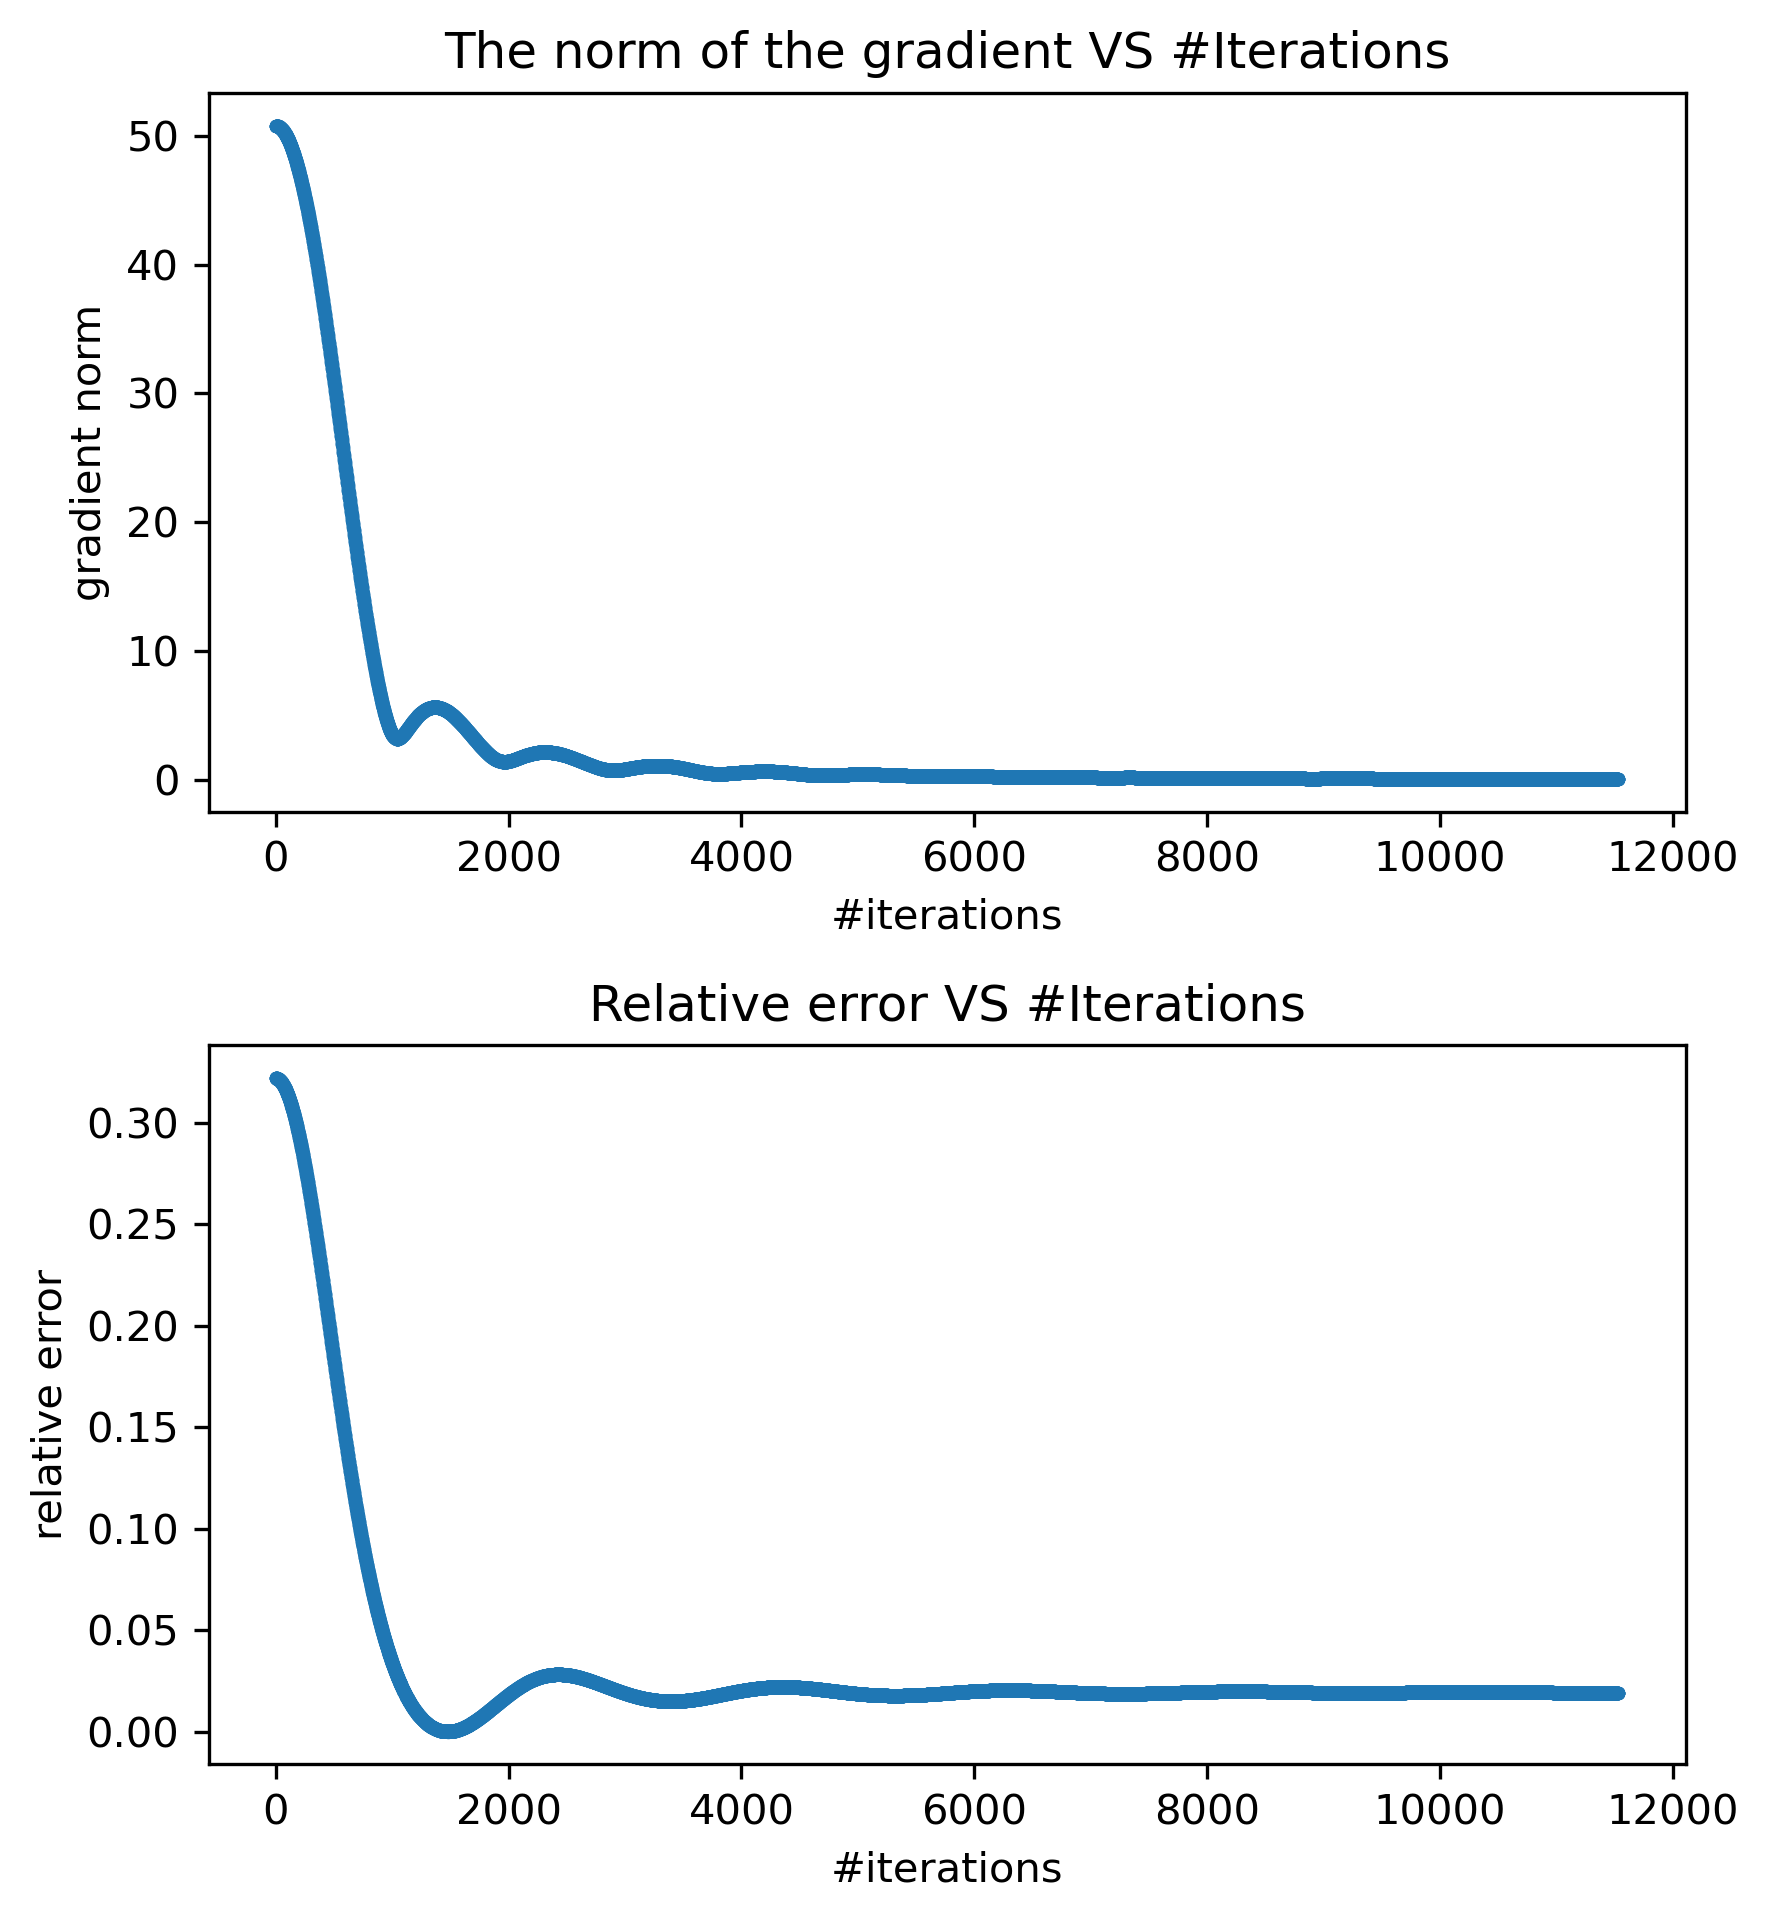

In [82]:
plot_convergence_figure(f,x_lst,gradient_lst,options,A)

In [83]:
solution_200_dot_6 = [x_lst,gradient_lst,time_lst]
save_solution(solution_200_dot_6,'solution_200_dot_6_agm.bin')

E:/ds-courses/term3/MDS6106 OP/final/datasets/solution/solution_200_dot_6_agm.bin


In [53]:
# L_inf Norm
def f_inf(x,a,lambda1,delta):
    f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))
    x_diff = list()
    f_2 = 0
    for i in range(len(a)):
    # for j in range(i+1,len(a)):
    #   x_diff.append(x[i]-x[j])
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=np.inf, axis=1)
        mask = xi_diff_norm <= delta
        f_2 += np.sum(xi_diff_norm[mask] ** 2 / (2*delta))
        f_2 += np.sum(xi_diff_norm[~mask] - delta/2)

      #f_2 = phi(x_diff,delta)
    return 1/2*(f_1) + lambda1 * f_2

def g_inf(x,a,lambda1,delta):
    grad_1 = x - a
    grad_2 = np.zeros(x.shape)
    for i in range(x.shape[0]):
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=np.inf, axis=1)
        mask = xi_diff_norm <= delta

        argmax = np.argmax(np.abs(xi_diff), axis=1)
        grad_2[i] += lambda1 * np.sum(np.expand_dims(xi_diff[mask][np.arange(mask.sum()), np.argmax(xi_diff[mask], axis=1)], axis=1) * np.eye(xi_diff.shape[1])[np.argmax(xi_diff[mask], axis=1)] / delta, axis=0)
        grad_2[i] += lambda1 * np.sum(np.expand_dims(np.sign(np.argmax(xi_diff[~mask], axis=1)), axis=1) * np.eye(xi_diff.shape[1])[np.argmax(xi_diff[~mask], axis=1)], axis=0)
        
    #grad_2[i] += lambda1 * np.sum(xi_diff[mask] / delta, axis=0)
    #grad_2[i] += lambda1 * np.sum(xi_diff[~mask] / np.expand_dims(xi_diff_norm[~mask], axis=1), axis=0) 


    return grad_1 + grad_2

In [54]:
T1 = time.time()
options = {
    "lambda":0.05,
    "delta":1e-4,
    "tol":1e-1,
    "isprint":True
}
solution_inf,x_lst_inf,gradient_lst_inf,time_lst_inf = invoke_AGM(f_inf,g_inf,A,options)
T2 = time.time()
_time_inf = T2-T1

<ipython-input-53-cdafd3d8f3aa>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


Iteration: 0 obj: 8209.901427961777 norm_gradient: 48.016391870815085 time:0.09s
Iteration: 400 obj: 8176.234515107639 norm_gradient: 37.25883351822257 time:25.21s
Iteration: 800 obj: 8447.657007819322 norm_gradient: 14.713705669667958 time:49.05s
Iteration: 1200 obj: 8945.564449787245 norm_gradient: 2.631371748485892 time:74.24s
Iteration: 1600 obj: 9069.973415862418 norm_gradient: 5.610645491138941 time:99.38s
Iteration: 2000 obj: 8889.938633142723 norm_gradient: 1.2477854324450686 time:123.41s
Iteration: 2400 obj: 8781.345832017802 norm_gradient: 2.432837975230293 time:147.74s
Iteration: 2800 obj: 8820.825173834039 norm_gradient: 1.447574613835473 time:172.69s
Iteration: 3200 obj: 8895.692905405567 norm_gradient: 1.0223206580388686 time:196.84s
Iteration: 3600 obj: 8904.015741817826 norm_gradient: 1.1998987309976112 time:223.99s
Iteration: 4000 obj: 8862.377319127545 norm_gradient: 0.591228017988172 time:249.40s
Iteration: 4400 obj: 8837.888267333852 norm_gradient: 0.903521622236445

In [ ]:
plot_convergence_figure(f_inf,x_lst_inf,gradient_lst_inf,options,A)

In [55]:
solution_200_dot_6_inf = [x_lst_inf,gradient_lst_inf,time_lst_inf]
save_solution(solution_200_dot_6_inf,'solution_200_dot_6_inf.bin')

E:/ds-courses/term3/MDS6106 OP/final/datasets/solution/solution_200_dot_6_inf.bin


In [46]:
# L1 Norm
def f_l1(x,a,lambda1,delta):
    f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))
    x_diff = list()
    f_2 = 0
    for i in range(len(a)):
    # for j in range(i+1,len(a)):
    #   x_diff.append(x[i]-x[j])
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=1, axis=1)
        mask = xi_diff_norm <= delta
        f_2 += np.sum(xi_diff_norm[mask] ** 2 / (2*delta))
        f_2 += np.sum(xi_diff_norm[~mask] - delta/2)

      #f_2 = phi(x_diff,delta)
    return 1/2*(f_1) + lambda1 * f_2

def g_l1(x,a,lambda1,delta):
    grad_1 = x - a
    grad_2 = np.zeros(x.shape)
    for i in range(x.shape[0]):
        xi_diff = x[i] - x[i+1:]
        xi_diff_norm = norm(xi_diff, ord=1, axis=1)
        mask = xi_diff_norm <= delta

        grad_2[i] += lambda1 * np.sum(np.expand_dims(xi_diff_norm[mask], axis=1) * np.sign(xi_diff[mask]) / delta, axis=0)
        grad_2[i] += lambda1 * np.sum(np.sign(xi_diff[~mask]), axis=0) 

    return grad_1 + grad_2

In [47]:
T1 = time.time()
options = {
    "lambda":0.05,
    "delta":1e-4,
    "tol":1e-1,
    "isprint":True
}
solution_l1,x_lst_l1,gradient_lst_l1,time_lst_l1 = invoke_AGM(f_l1,g_l1,A,options)
T2 = time.time()
_time_l1 = T2-T1

<ipython-input-46-f791c57a06ab>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


Iteration: 0 obj: 11109.872907824629 norm_gradient: 66.34027418484429 time:0.07s
Iteration: 400 obj: 10003.324705784955 norm_gradient: 46.92133923015091 time:8.04s
Iteration: 800 obj: 8465.28230901889 norm_gradient: 15.345907786613303 time:16.42s
Iteration: 1200 obj: 7827.326660466656 norm_gradient: 8.455453154193865 time:24.34s
Iteration: 1600 obj: 7770.82134566456 norm_gradient: 5.373880140497313 time:32.05s
Iteration: 2000 obj: 7902.134474639915 norm_gradient: 3.3856310406128696 time:40.67s
Iteration: 2400 obj: 7986.34448261059 norm_gradient: 3.4196368749193757 time:51.60s
Iteration: 2800 obj: 7959.051457055306 norm_gradient: 3.149444996119251 time:59.83s
Iteration: 3200 obj: 7905.566255038429 norm_gradient: 2.444106723972934 time:68.33s
Iteration: 3600 obj: 7887.757519855857 norm_gradient: 3.2067902577768015 time:78.84s
Iteration: 4000 obj: 7910.918788699132 norm_gradient: 2.6337704126665873 time:91.35s
Iteration: 4400 obj: 7941.416607141443 norm_gradient: 2.770732285241838 time:10

<ipython-input-46-f791c57a06ab>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


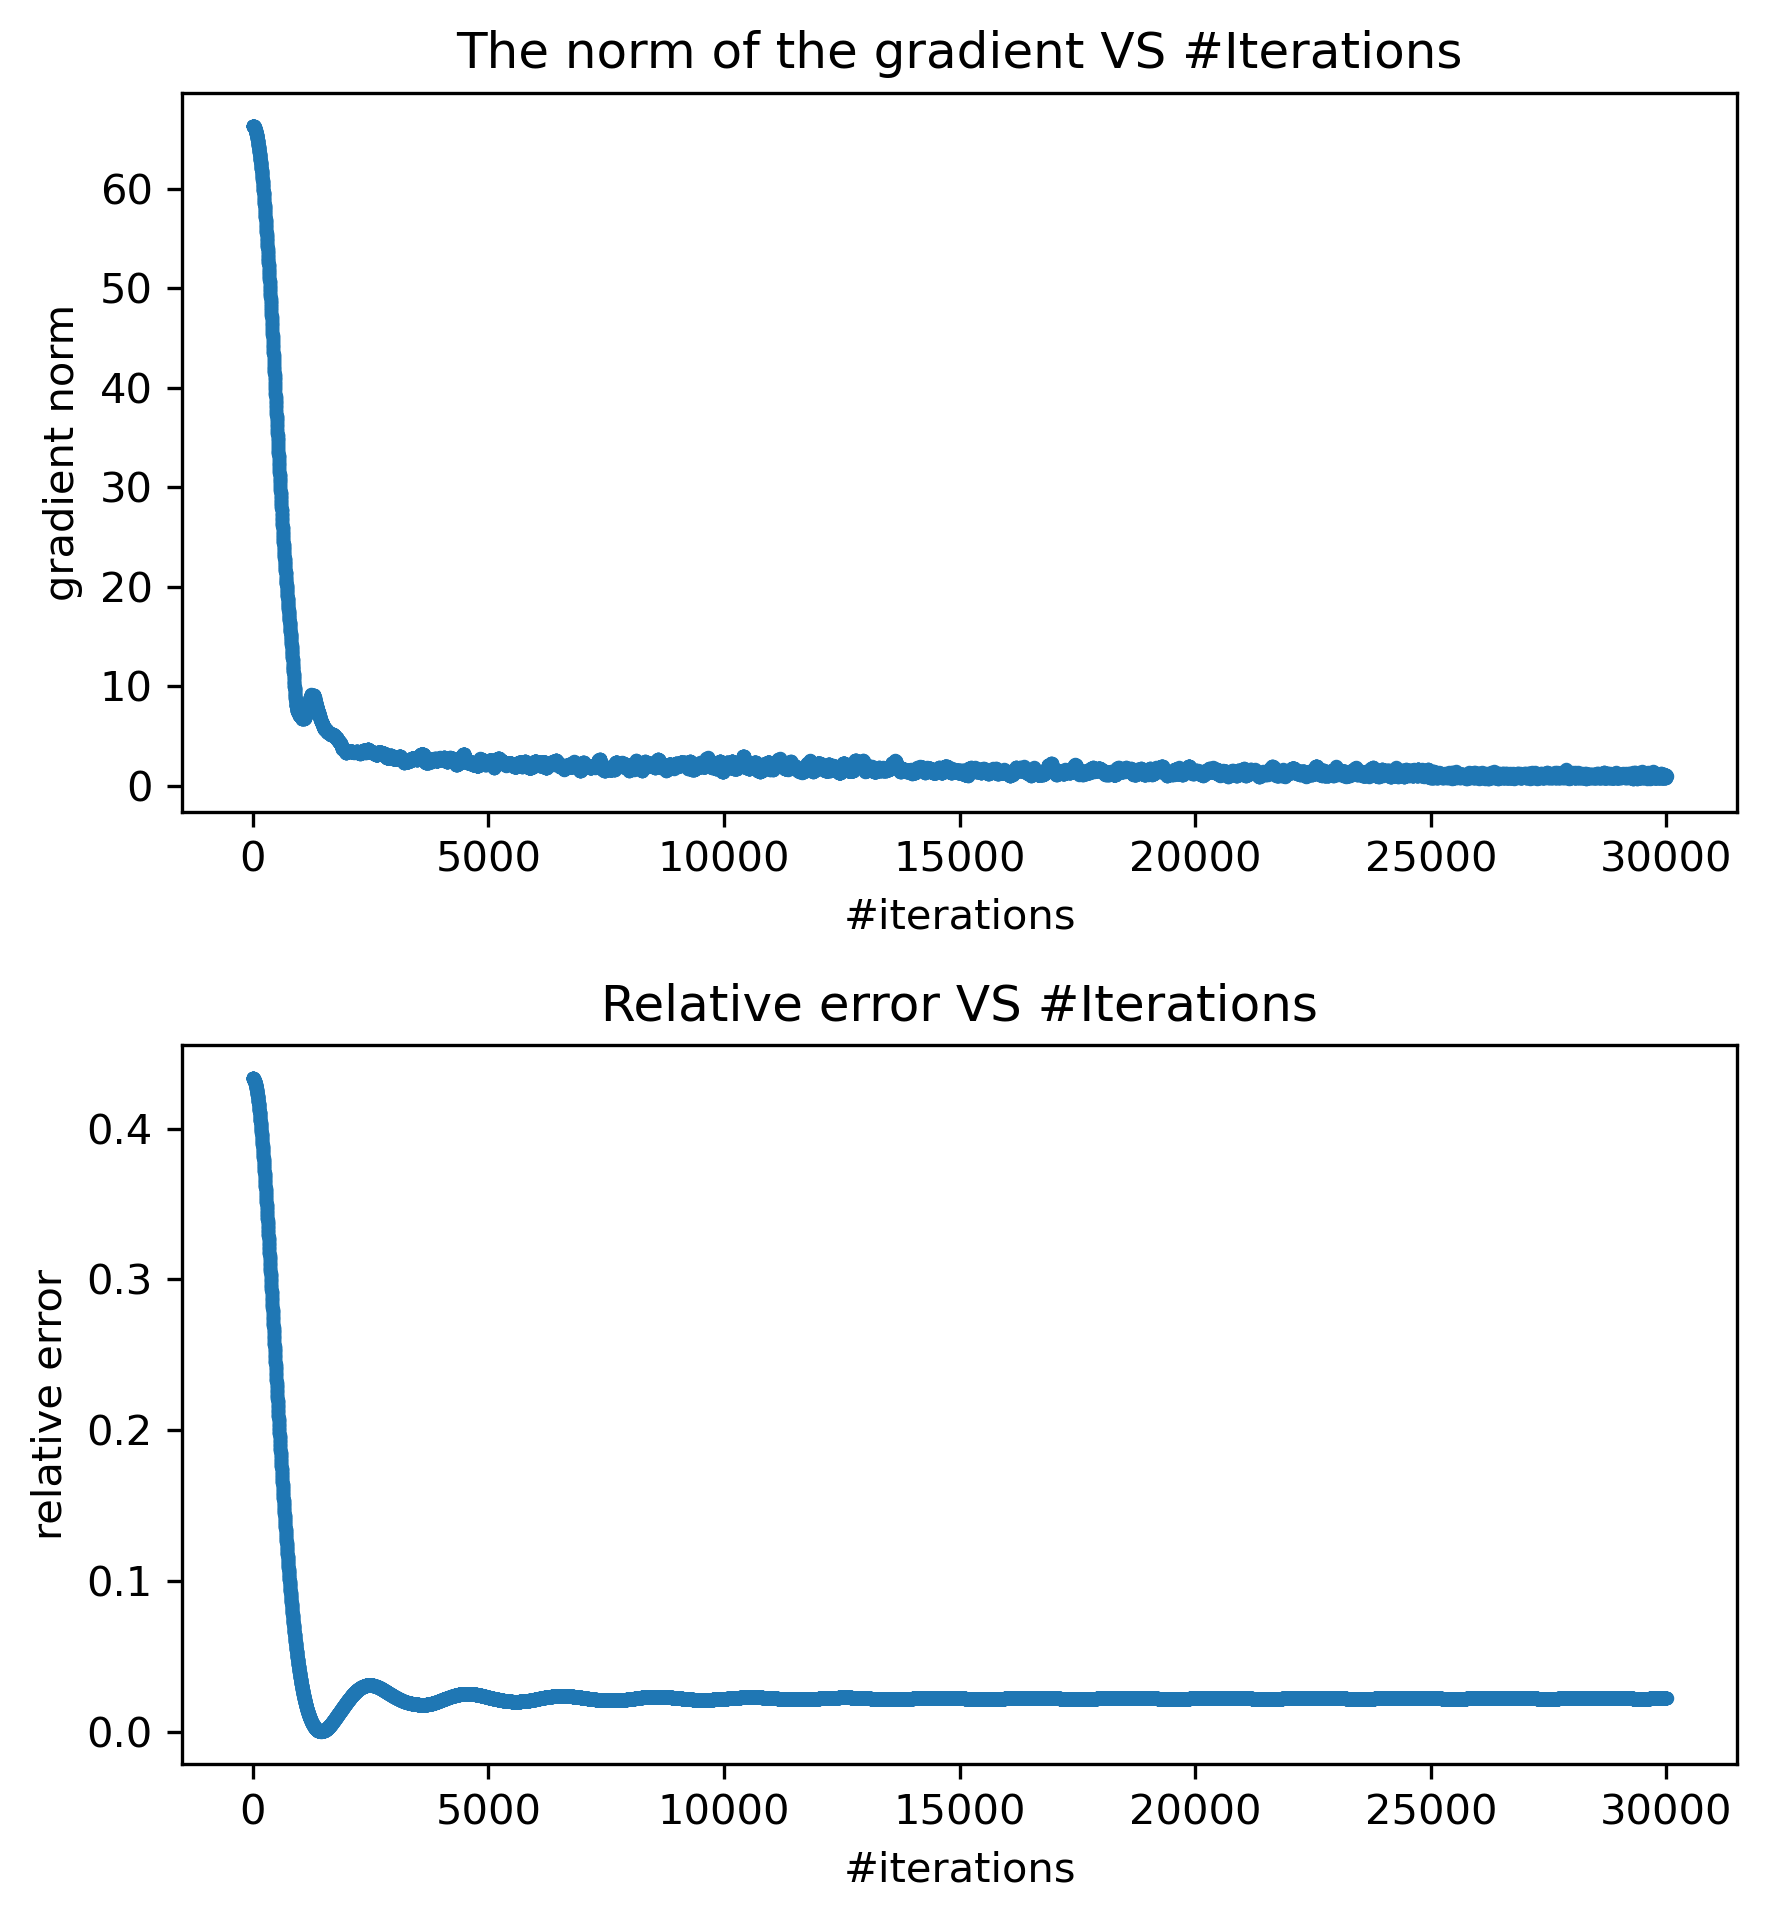

In [49]:
plot_convergence_figure(f_l1,x_lst_l1,gradient_lst_l1,options,A)

In [50]:
solution_200_dot_6_l1 = [x_lst_l1,gradient_lst_l1,time_lst_l1]
save_solution(solution_200_dot_6_l1,'solution_200_dot_6_l1.bin')

E:/ds-courses/term3/MDS6106 OP/final/datasets/solution/solution_200_dot_6_l1.bin


Text(0, 0.5, 'gradient norm')

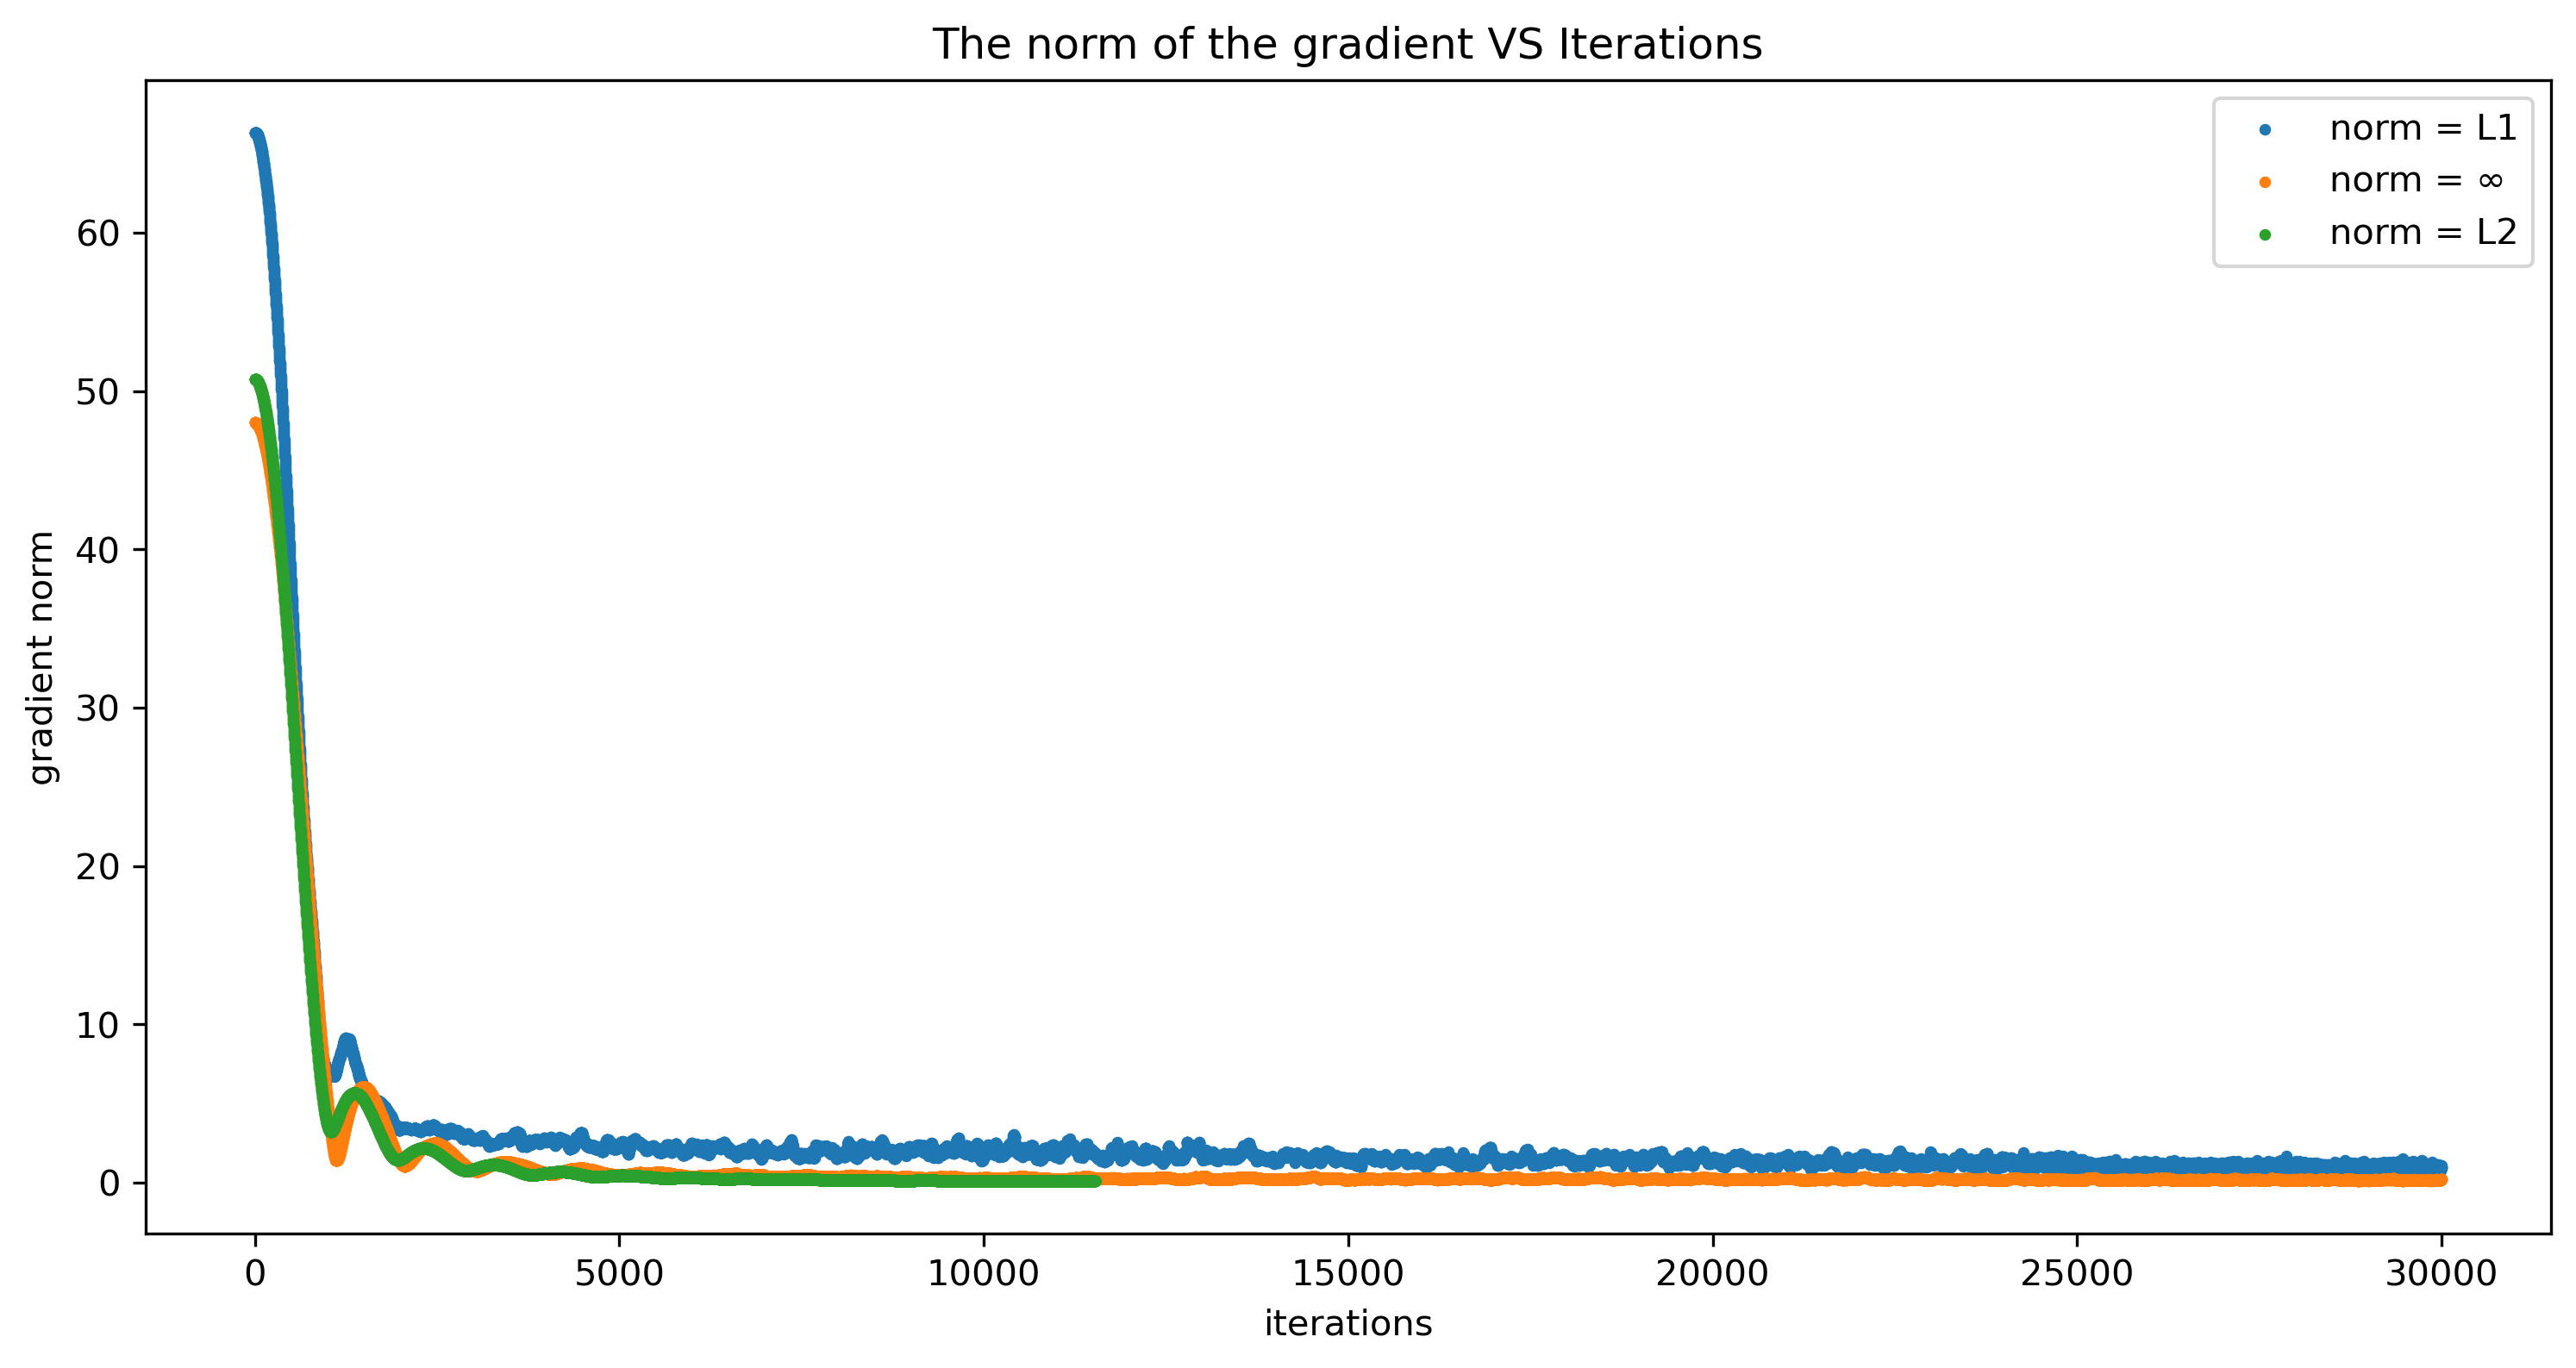

In [87]:
plt.figure(dpi = 300, figsize=(12, 13))
ax1 = plt.subplot(2, 1, 1)
ax1.scatter(range(len(gradient_lst_l1)), gradient_lst_l1, s = 5, label='norm = L1')
ax1.scatter(range(len(gradient_lst_inf)),gradient_lst_inf, s = 5, label='norm = ∞')
ax1.scatter(range(len(gradient_lst)), gradient_lst, s = 5, label='norm = L2')
plt.title("The norm of the gradient VS Iterations")
plt.legend()
ax1.set_xlabel('iterations')
ax1.set_ylabel('gradient norm')

<ipython-input-74-d0f3945137cf>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))
<ipython-input-46-f791c57a06ab>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


Text(0, 0.5, 'relative error')

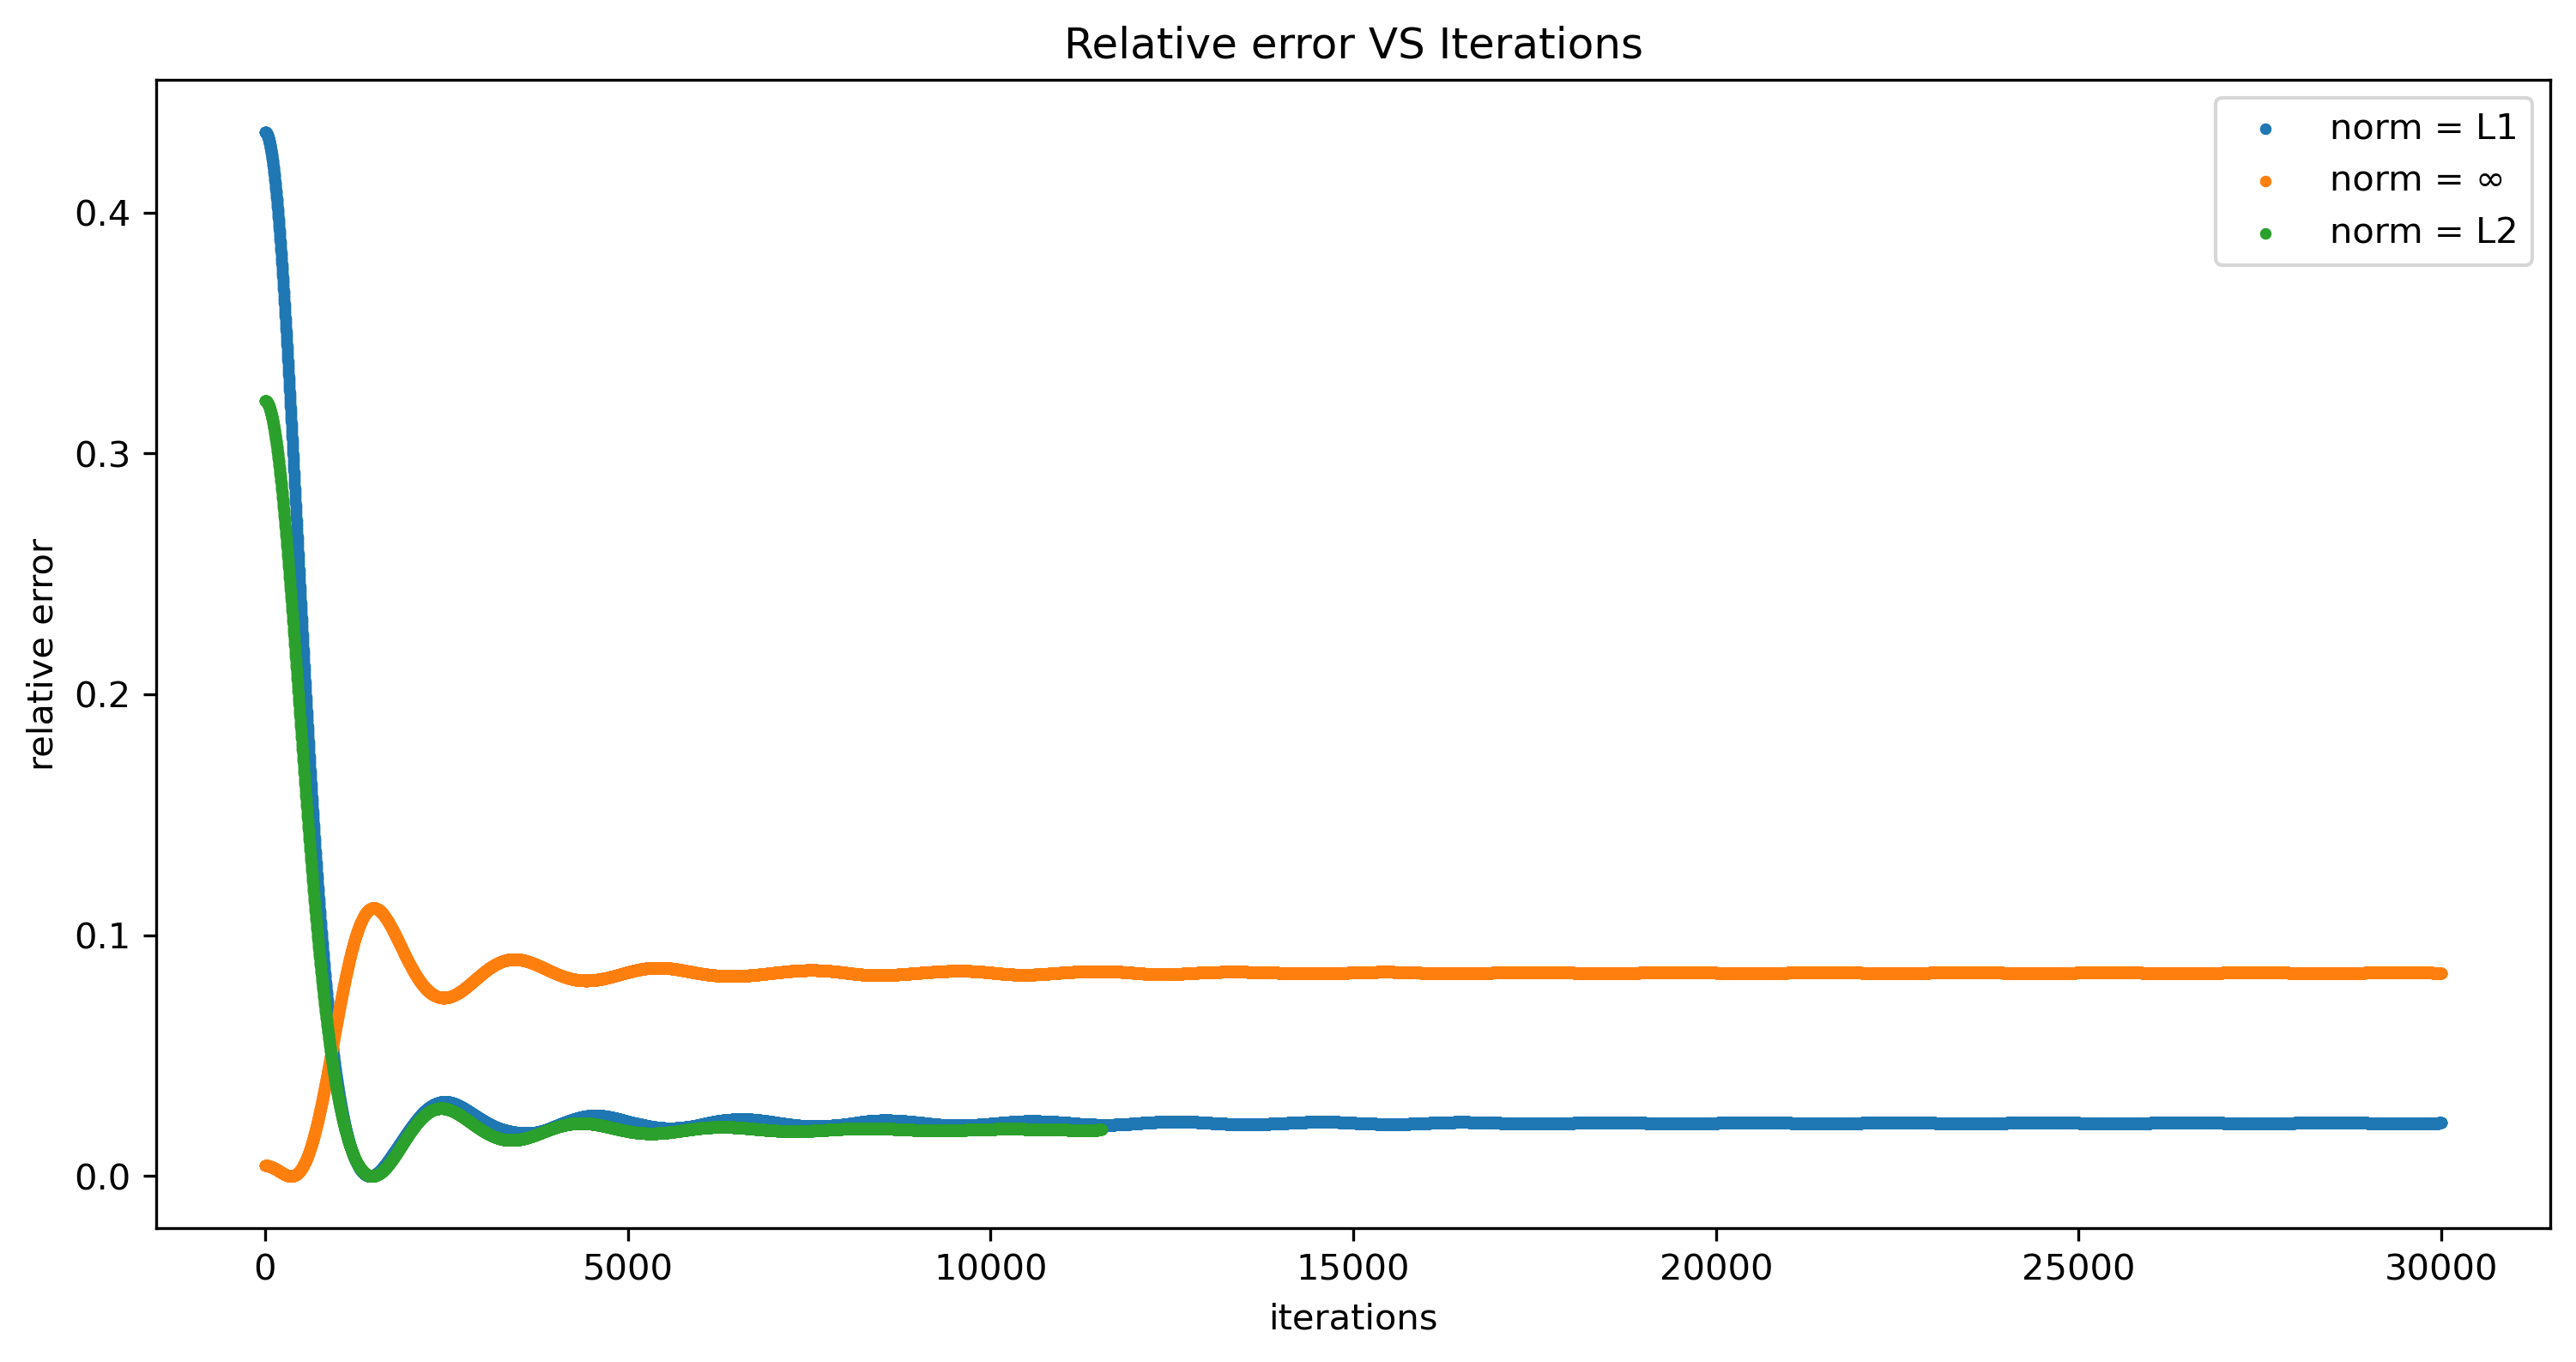

In [90]:
plt.figure(dpi = 300, figsize=(12, 13))
ax2 = plt.subplot(2, 1, 2)

best_function_value = min(f(each,A,lambda1,delta) for each in x_lst)
best_function_value_l1 = min(f_l1(each,A,lambda1,delta) for each in x_lst_l1)
best_function_value_inf = min(f_inf(each,A,lambda1,delta) for each in x_lst_inf)


ax2.scatter(range(len(x_lst_l1)), [abs(f_l1(each,A,lambda1,delta) - best_function_value_l1) / (max(1, abs(best_function_value_l1))) for each in x_lst_l1], s = 5,label='norm = L1')
ax2.scatter(range(len(x_lst_inf)), [abs(f_inf(each,A,lambda1,delta) - best_function_value_inf) / (max(1, abs(best_function_value_inf))) for each in x_lst_inf], s = 5,label='norm = ∞')
ax2.scatter(range(len(x_lst)), [abs(f(each,A,lambda1,delta) - best_function_value) / (max(1, abs(best_function_value))) for each in x_lst], s = 5,label='norm = L2')

plt.title("Relative error VS Iterations")
plt.legend()
ax2.set_xlabel('iterations')
ax2.set_ylabel('relative error')

<ipython-input-53-cdafd3d8f3aa>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  f_1 = np.sum((norm(x[i]-a[i]))**2 for i in range(len(x)))


Text(0, 0.5, 'relative error')

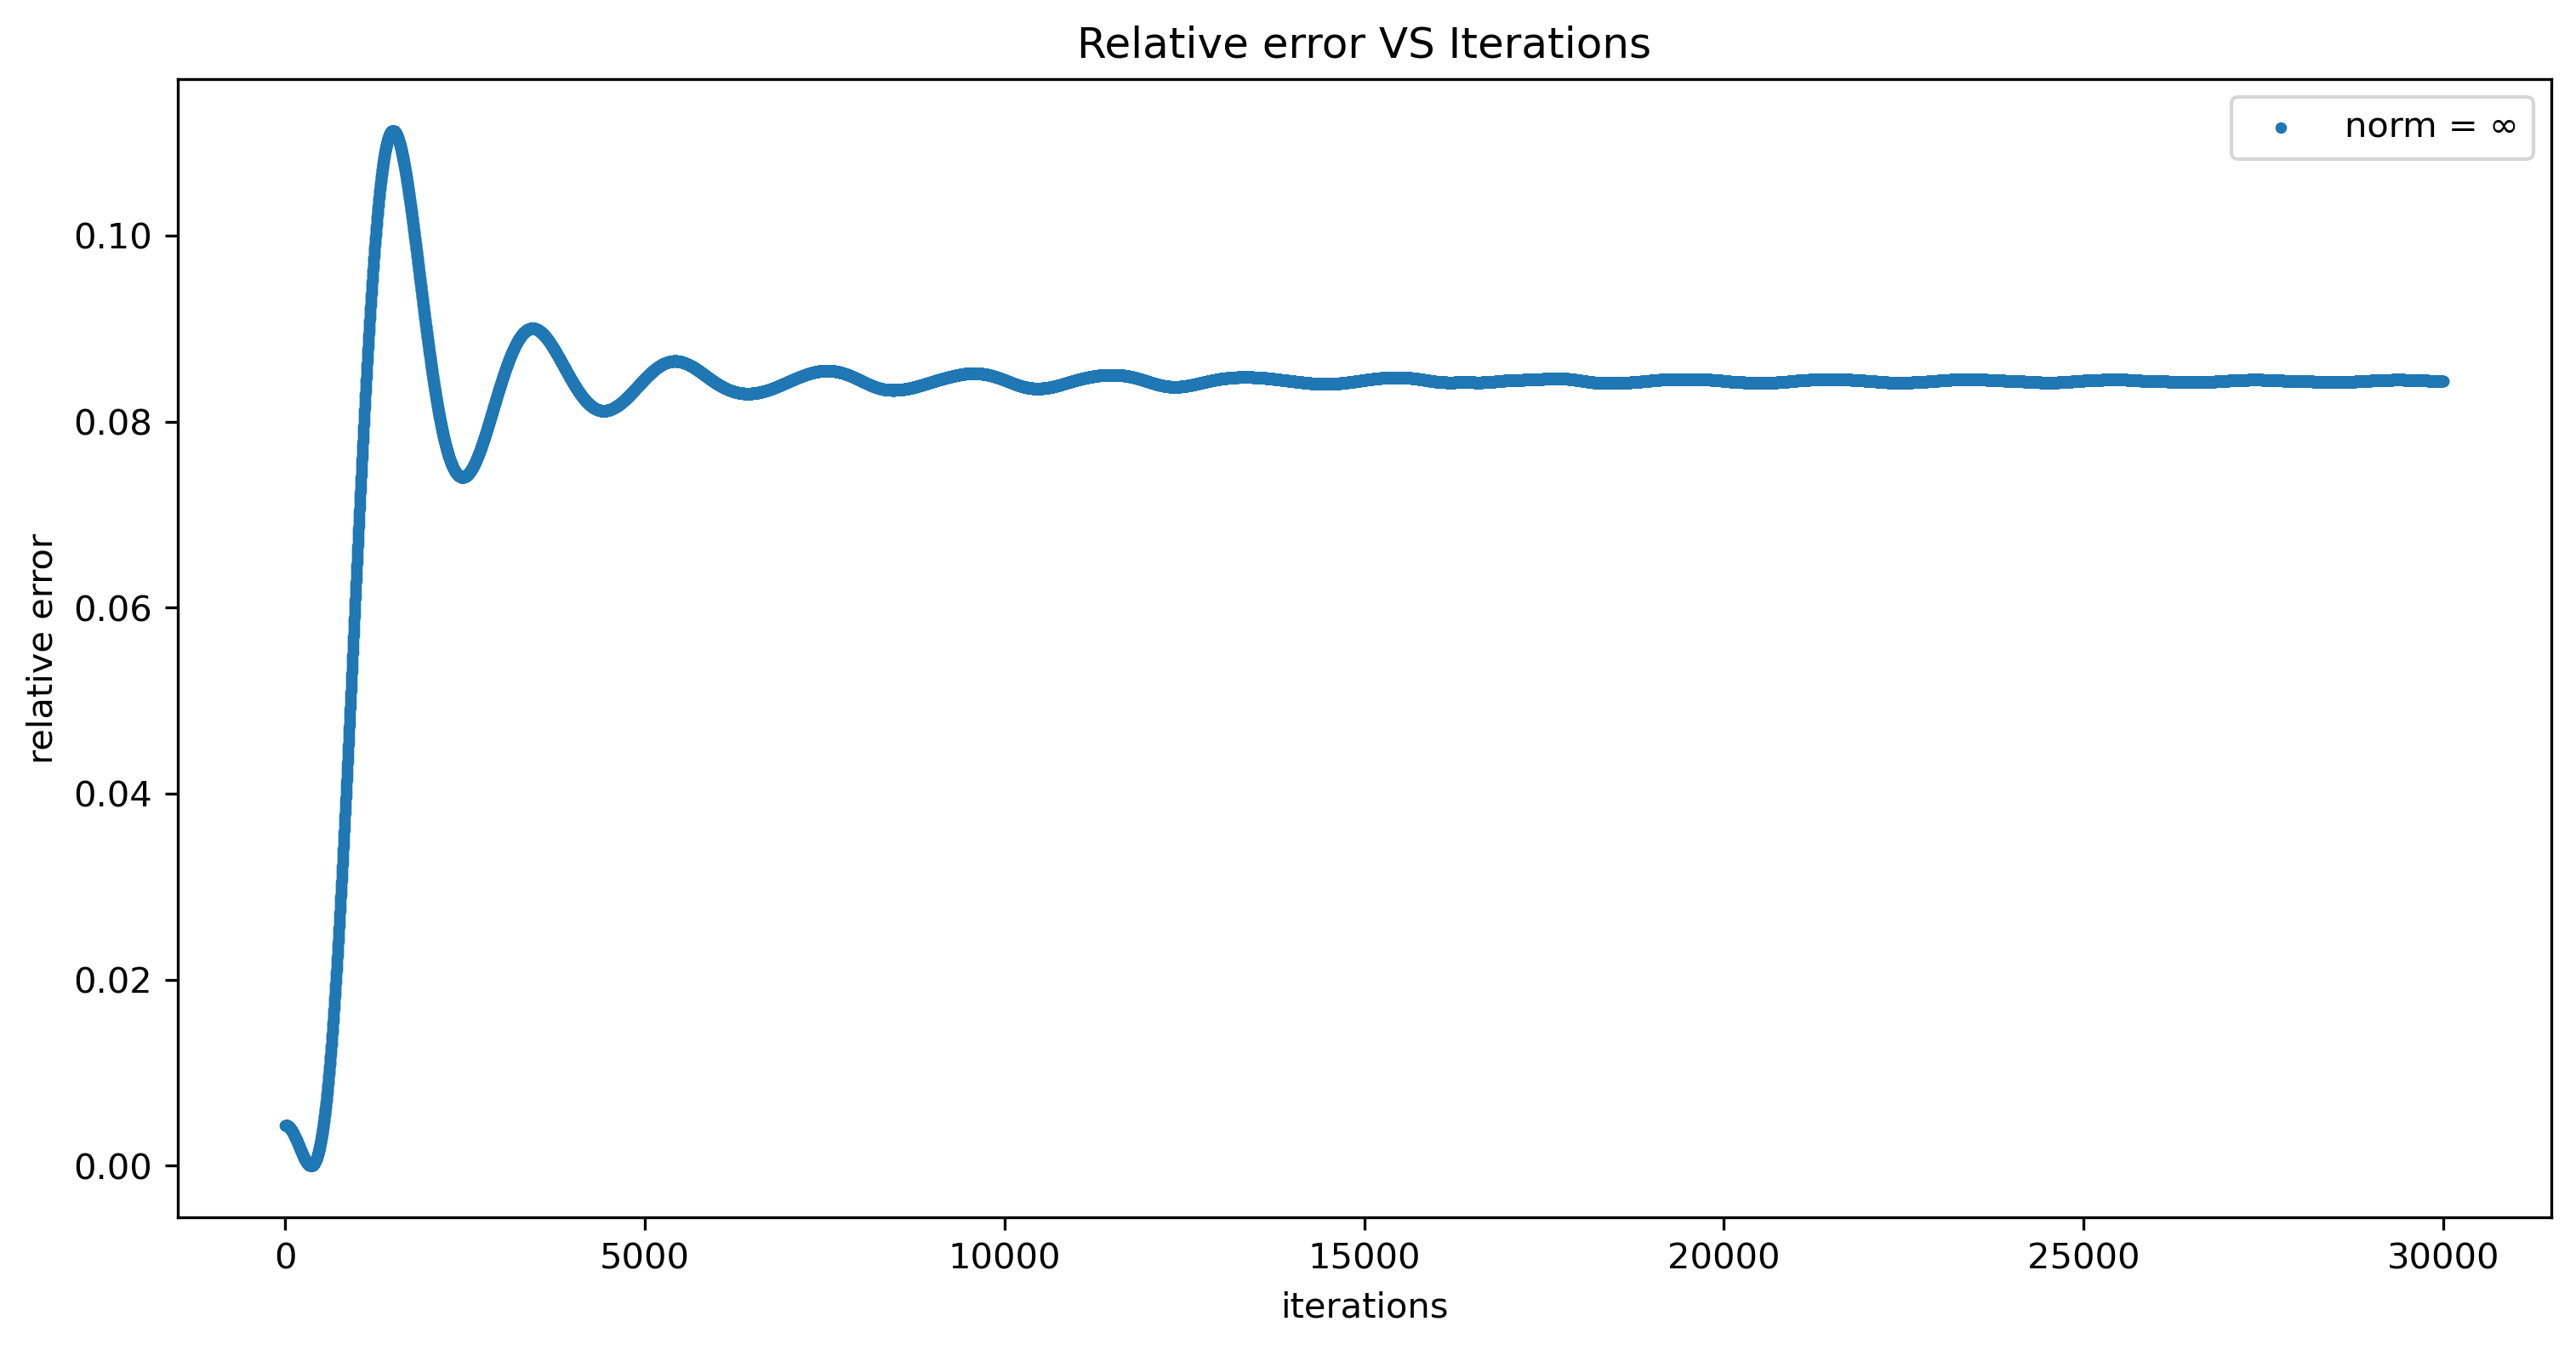

In [91]:
plt.figure(dpi = 300, figsize=(12, 13))
ax2 = plt.subplot(2, 1, 2)
best_function_value_inf = min(f_inf(each,A,lambda1,delta) for each in x_lst_inf)
ax2.scatter(range(len(x_lst_inf)), [abs(f_inf(each,A,lambda1,delta) - best_function_value_inf) / (max(1, abs(best_function_value_inf))) for each in x_lst_inf], s = 5,label='norm = ∞')
plt.title("Relative error VS Iterations")
plt.legend()
ax2.set_xlabel('iterations')
ax2.set_ylabel('relative error')